In [1]:
import requests, zipfile, io
import pandas as pd
from bs4 import BeautifulSoup
import re
import datetime as dt  
import numpy as np
from dotenv import load_dotenv
load_dotenv()
import base64
import os
import requests
import json
pd.set_option('display.max_colwidth', -1)
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
import seaborn as sns

%matplotlib inline
plt.style.use('fivethirtyeight')

genius_api_key = os.getenv("GENIUS_ACCESS")

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import sys

import altair as alt
import altair_latimes as lat
alt.renderers.enable('notebook')
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')

spotify_client_id = os.getenv("SPOTIFY_CLIENT_ID")
spotify_client_secret = os.getenv("SPOTIFY_CLIENT_SECRET")
token = os.getenv("SPOTIFY_ACCESS_TOKEN")

In [2]:
filepath = "NRC-Emotion-Lexicon/NRC-Emotion-Lexicon-v0.92/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
emolex_df = pd.read_csv(filepath,  names=["word", "emotion", "association"], skiprows=45, sep='\t')
emo_df = emolex_df[((emolex_df.emotion == 'sadness') | (emolex_df.emotion == 'fear')) & (emolex_df.association == 1)]

# This one uses <code>Spotify's API</code>
- retains special info
- refresh my access token every damn hour (https://developer.spotify.com/console/get-track/?id=3n3Ppam7vgaVa1iaRUc9Lp)

In [13]:
token = f"Bearer {token}"
base_url = "https://api.spotify.com/v1"
headers = {'Authorization': token}
search_url = base_url + "/search"

# searching for artists under the emo genre
params = {'q':'genre:emo', 'type':'artist', 'limit': 10}
response = requests.get(search_url, params=params, headers=headers).json()
# print(response)

songs = []
# looping through the emo artist results
for artist in response['artists']['items']:
    row = {}
    
    row['artist_name'] = artist['name']
    row['artist_popularity'] = artist['popularity']
    row['artist_genres'] = artist['genres']
    row['artist_followers'] = artist['followers']['total']
    
#   pulling the artist from the genre search
    base_url = "https://api.spotify.com/v1"
    headers = {'Authorization': token}
    top_tracks_params = {'country':'from_token', 'id': artist['id']}
    top_tracks_search_url = base_url + "/artists/" + artist['id'] + "/top-tracks"
    response_top_tracks = requests.get(top_tracks_search_url, params=top_tracks_params, headers=headers).json()
    for track in response_top_tracks['tracks'][:3]:
        print(artist['name'], "|", track['name'])
        try:
            row['song_album'] = track['album']['name']
        except:
            row['song_album'] = "nan"
        row['song_title'] = track['name']
        row['song_explicit'] = track['explicit']
        row['song_preview_url'] = track['preview_url']
        row['song_popularity'] = track['popularity']
        row['song_id'] = track['id']
         
        search_url = base_url + "/audio-features/" + track['id']
        response_track_features = requests.get(search_url, headers=headers).json()
        for key in response_track_features.keys():
            row[key] = response_track_features[key]
        
#          scraping the lyrics from Genius        
#         genius_base_url = "http://api.genius.com"
#         genius_headers = {'Authorization': f'Bearer {genius_api_key}'}
#         genius_search_url = genius_base_url + "/search"
#         ## searching using the track name
#         genius_params = {'q': track['name']}
#         response_genius = requests.get(genius_search_url, params=genius_params, headers=genius_headers).json()
#         for hit in response_genius['response']['hits'][:1]:
#             row['lyrics_url'] = base_url + hit['result']['path']
            
#             song_path = hit['result']['api_path']
#             headers = {'Authorization': f'Bearer {genius_api_key}'}
#             song_url = genius_base_url + song_path
#             response = requests.get(song_url, headers=headers)
#             json = response.json()
#             path = json["response"]["song"]["path"]
#             page_url = "http://genius.com" + path
#             page = requests.get(page_url)
#             html = BeautifulSoup(page.text, "html.parser")
#             [h.extract() for h in html('script')]
#             lyrics = html.find("div", class_="lyrics").get_text()
#             lyrics = lyrics.replace('\n', ' ')
#             row['lyrics'] = lyrics.lower()
            
            
            songs.append(row)
        
songs_df = pd.DataFrame(songs)

XXXTENTACION | SAD!
XXXTENTACION | Moonlight
XXXTENTACION | Jocelyn Flores
Panic! At The Disco | High Hopes
Panic! At The Disco | ME! (feat. Brendon Urie of Panic! At The Disco)
Panic! At The Disco | Hey Look Ma, I Made It
6ix9ine | FEFE
6ix9ine | BEBE
6ix9ine | KIKA
Fall Out Boy | Summer Days (feat. Macklemore & Patrick Stump of Fall Out Boy)
Fall Out Boy | Centuries
Fall Out Boy | Sugar, We're Goin Down
Lil Peep | Falling Down - Bonus Track
Lil Peep | Save That Shit
Lil Peep | Star Shopping
My Chemical Romance | Welcome to the Black Parade
My Chemical Romance | Teenagers
My Chemical Romance | I'm Not Okay (I Promise)
Paramore | Still into You
Paramore | Ain't It Fun
Paramore | Hard Times
iann dior | gone girl
iann dior | emotions
iann dior | molly
Lil Pump | Arms Around You (feat. Maluma & Swae Lee)
Lil Pump | I Love It (& Lil Pump)
Lil Pump | Gucci Gang
Josh A | Suicidal Thoughts
Josh A | Gucci Coffin
Josh A | Endless Nightmare


In [5]:
songs_df.to_csv('spotify_genre_emo.csv', index=False)

In [3]:
songs_df = pd.read_csv('spotify_genre_emo.csv')
songs_df.sort_values('artist_popularity', ascending=False).artist_name.unique()

array(['XXXTENTACION', 'Panic! At The Disco', 'Fall Out Boy', 'Lil Peep',
       '6ix9ine', 'Lil Pump', 'Paramore', 'My Chemical Romance',
       'iann dior', 'Josh A'], dtype=object)

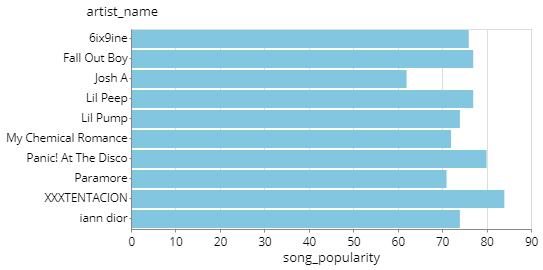

In [53]:
pop_df = pd.DataFrame(songs_df.groupby('artist_name').song_popularity.mean().sort_values(ascending=False).reset_index())
chart = alt.Chart(pop_df,width=400, height=200).mark_bar().encode(x='song_popularity', y='artist_name')


In [86]:
# client_credentials_manager = SpotifyClientCredentials(client_id=spotify_client_id, client_secret=spotify_client_secret)
# sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# base_url = "https://api.spotify.com/v1"
# search_url = base_url + "/search"
# # headers = {'Authorization': f"Bearer {spotify_api_key}"}
# # params = {'q': 'genre:emo', 'type': 'artist', 'limit': 1}

# response = sp.search(q='genre:emo', type='artist', limit=1)

# songs = []
# for artist in response['artists']['items']:
#     row = {}
    
#     row['artist_name'] = artist['name']
#     row['artist_popularity'] = artist['popularity']
#     row['artist_genres'] = artist['genres']
    
# #     set up to iterate only through the first track
#     for song in sp.artist_top_tracks(artist['id'], country='US')['tracks'][:2]:
# #         print(song)
#         row['title'] = song['name']
#         row['explicit'] = song['explicit']
#         row['preview'] = song['preview_url']
#         row['popularity'] = song['popularity']
        
#         print(artist['name'], "|", song['name'])
        
#         response_track_features = sp.audio_features(tracks=song['id'])
#         for features in response_track_features:
#             for feature in features.keys():
#                 row[feature] = features[feature]
#             print(sp.track(features['uri']))
            
# #         base_url = "http://api.genius.com"
# #         headers = {'Authorization': f'Bearer {genius_api_key}'}
# #         search_url = base_url + "/search"
# #         artist_name = artist['name']
# #         song_title = song['name']
# #         params = {'q': artist_name + song_title}
# #         response = requests.get(search_url, params=params, headers=headers).json()
# #         for song in response['response']['hits'][:1]:

# #         #     getting some of the meta data
# #             row['lyrics_url'] = base_url + song['result']['path']
            
# #         #  scraping the lyrics from genius
# #             base_url = "http://api.genius.com"
# #             song_path = song['result']['api_path']
# #             headers = {'Authorization': f'Bearer {genius_api_key}'}
# #             song_url = base_url + song_path
# #             response = requests.get(song_url, headers=headers)
# #             json = response.json()
# #             path = json["response"]["song"]["path"]
# #             page_url = "http://genius.com" + path
# #             page = requests.get(page_url)
# #             html = BeautifulSoup(page.text, "html.parser")
# #             [h.extract() for h in html('script')]
# #             lyrics = html.find("div", class_="lyrics").get_text()
# #             lyrics = lyrics.replace('\n', ' ')
# #             row['lyrics'] = lyrics.lower()

#         #     throw it in the dictionary
# #             songs.append(row)
# #             print(f"Grabbing the lyrics for {song['result']['primary_artist']['name']}, {song['result']['title_with_featured']}")

XXXTENTACION | SAD!
{'album': {'album_type': 'album', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/15UsOTVnJzReFVN1VCnxy4'}, 'href': 'https://api.spotify.com/v1/artists/15UsOTVnJzReFVN1VCnxy4', 'id': '15UsOTVnJzReFVN1VCnxy4', 'name': 'XXXTENTACION', 'type': 'artist', 'uri': 'spotify:artist:15UsOTVnJzReFVN1VCnxy4'}], 'available_markets': ['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH', 'BO', 'BR', 'CA', 'CH', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HU', 'ID', 'IE', 'IL', 'IN', 'IS', 'IT', 'JO', 'JP', 'KW', 'LB', 'LI', 'LT', 'LU', 'LV', 'MA', 'MC', 'MT', 'MX', 'MY', 'NI', 'NL', 'NO', 'NZ', 'OM', 'PA', 'PE', 'PH', 'PL', 'PS', 'PT', 'PY', 'QA', 'RO', 'SA', 'SE', 'SG', 'SK', 'SV', 'TH', 'TN', 'TR', 'TW', 'US', 'UY', 'VN', 'ZA'], 'external_urls': {'spotify': 'https://open.spotify.com/album/2Ti79nwTsont5ZHfdxIzAm'}, 'href': 'https://api.spotify.com/v1/albums/2Ti79nwTsont5ZHfdxIzAm', 

In [77]:
for song in songs:
    print(song['preview'])

None
None
None
None
https://p.scdn.co/mp3-preview/bda115bbf4f1de770a9809a2d28dbde92b00b208?cid=de12d73a562343b68e7a6516e08da5fd
https://p.scdn.co/mp3-preview/bda115bbf4f1de770a9809a2d28dbde92b00b208?cid=de12d73a562343b68e7a6516e08da5fd
None
https://p.scdn.co/mp3-preview/8058676c82db42a04ceceb90826af22f7726768a?cid=de12d73a562343b68e7a6516e08da5fd


In [4]:
# setting up the api search w/ the artist I'm looking for
base_url = "http://api.genius.com"
headers = {'Authorization': f'Bearer {genius_api_key}'}
search_url = base_url + "/search"
artist_name = artist['name']
song_title = song['name']
params = {'q': artist_name}
response = requests.get(search_url, params=params, headers=headers).json()

songs = []
for song in response['response']['hits']:
    song_dict = {}
    
#     getting some of the meta data
    song_dict['artist'] = song['result']['primary_artist']['name']
    song_dict['title'] = song['result']['title_with_featured']
    song_dict['api_path'] = base_url + song['result']['api_path']
    song_dict['album_art'] = song['result']['header_image_url']
    song_dict['lyrics_url'] = base_url + song['result']['path']
    
#  scraping the lyrics
    base_url = "http://api.genius.com"
    song_path = song['result']['api_path']
    headers = {'Authorization': f'Bearer {genius_api_key}'}
    song_url = base_url + song_path
    response = requests.get(song_url, headers=headers)
    json = response.json()
    path = json["response"]["song"]["path"]
    page_url = "http://genius.com" + path
    page = requests.get(page_url)
    html = BeautifulSoup(page.text, "html.parser")
    [h.extract() for h in html('script')]
    lyrics = html.find("div", class_="lyrics").get_text()
    lyrics = lyrics.replace('\n', ' ')
    song_dict['lyrics'] = lyrics.lower()
    
#     throw it in the dictionary
    songs.append(song_dict)
    print(f"Grabbing the lyrics for {song['result']['primary_artist']['name']}, {song['result']['title_with_featured']}")

Grabbing the lyrics for Lil Peep, Star Shopping
Grabbing the lyrics for Lil Peep & XXXTENTACION, Falling Down
Grabbing the lyrics for Lil Peep, Save That Shit
Grabbing the lyrics for Lil Peep, Benz Truck (Гелик)
Grabbing the lyrics for Lil Peep & Lil Tracy, Witchblades
Grabbing the lyrics for Lil Peep, Awful Things (Ft. Lil Tracy)
Grabbing the lyrics for Lil Peep, ​Beamer Boy
Grabbing the lyrics for Marshmello & Lil Peep, Spotlight
Grabbing the lyrics for Lil Peep, Crybaby
Grabbing the lyrics for Lil Peep & Lil Tracy, ​White Wine


In [67]:
songs_df = pd.DataFrame(songs)
print(songs_df.head(1).lyrics)
songs_df.head(1).lyrics.str.replace('\[\w+: \]','', regex=True)

0      [intro: shiloh dynasty] i know you so well, so well i mean, i can do anything that he can i've been pretty—  [bridge: xxxtentacion & shiloh dynasty] i know you're somewhere, somewhere i've been trapped in my mind, girl, just holding on i don't wanna pretend we're something, we're nothing i've been stuck thinking 'bout her, i can't hold on (i'll be feeling)  [verse: xxxtentacion] i'm in pain, wanna put ten shots in my brain i've been trippin' 'bout some things, can't change suicidal, same time i'm tame picture this, in bed, get a phone call girl that you fucked with killed herself that was this summer when nobody helped and ever since then, man, i hate myself wanna fuckin' end it, pessimistic all wanna see me with no pot to piss in but niggas been excited 'bout the grave i'm diggin' havin' conversations 'bout my haste decisions fuckin' sickenin'; at the same time memories surface through the grapevine 'bout my uncle playin' with a slip knot post-traumatic stress got me fucked up 

0      [intro: shiloh dynasty] i know you so well, so well i mean, i can do anything that he can i've been pretty—  [bridge: xxxtentacion & shiloh dynasty] i know you're somewhere, somewhere i've been trapped in my mind, girl, just holding on i don't wanna pretend we're something, we're nothing i've been stuck thinking 'bout her, i can't hold on (i'll be feeling)  [verse: xxxtentacion] i'm in pain, wanna put ten shots in my brain i've been trippin' 'bout some things, can't change suicidal, same time i'm tame picture this, in bed, get a phone call girl that you fucked with killed herself that was this summer when nobody helped and ever since then, man, i hate myself wanna fuckin' end it, pessimistic all wanna see me with no pot to piss in but niggas been excited 'bout the grave i'm diggin' havin' conversations 'bout my haste decisions fuckin' sickenin'; at the same time memories surface through the grapevine 'bout my uncle playin' with a slip knot post-traumatic stress got me fucked up 

In [9]:
for word in emo_df.word:
    if re.findall(word, songs_df.lyrics[0]) != []:
        print(f"{word} shows up {len(re.findall(word, songs_df.lyrics[0]))} time")

art shows up 1 time
elf shows up 1 time
fall shows up 2 time
music shows up 1 time
rot shows up 1 time
rot shows up 1 time
sin shows up 1 time
sin shows up 1 time
wan shows up 1 time
wan shows up 1 time


In [189]:
songs_df.lyrics.str.replace('\[.+\]', '', regex=True)

0       Look at the sky tonight, all of the stars have a reason A reason to shine, a reason like mine and I'm fallin' to pieces Look at the sky tonight, all of the stars have a reason                                                                                                                                                                                                             
1       Come, let's watch the rain as it's falling down Oh-oh-oh, oh-oh, oh-oh Sunlight on your skin when I'm not around, yeah Oh-oh-oh, oh-oh, oh-oh Shit don't feel the same when you're out of town Oh-oh-oh, oh-oh, oh-oh So come, let's watch the rain as it's falling down Oh-oh-oh, oh-oh, oh-oh                                                                                             
2       Do I make you scared? Baby, won't you take me back? Nothin' like them other mothafuckas' I can make you rich (I can make you rich)                                                                                    

In [185]:
songs_df.api_url

0    http://api.genius.com/songs/2353006
1    http://api.genius.com/songs/3906162
2    http://api.genius.com/songs/3175124
3    http://api.genius.com/songs/3117098
4    http://api.genius.com/songs/2977800
5    http://api.genius.com/songs/3121880
6    http://api.genius.com/songs/2430998
7    http://api.genius.com/songs/3384913
8    http://api.genius.com/songs/2496168
9    http://api.genius.com/songs/2814605
Name: api_url, dtype: object

# Trying to get punk songs!



In [15]:
access_token = os.getenv("SPOTIFY_ACCESS_TOKEN")
token = f"Bearer {access_token}"
base_url = "https://api.spotify.com/v1"
headers = {'Authorization': token}
search_url = "https://api.spotify.com/v1/browse/categories/punk/playlists"

# searching for artists under the emo genre
params = {'limit':50}
response = requests.get(search_url, params=params, headers=headers).json()
response

{'playlists': {'href': 'https://api.spotify.com/v1/browse/categories/punk/playlists?offset=0&limit=50',
  'items': [{'collaborative': False,
    'external_urls': {'spotify': 'https://open.spotify.com/playlist/37i9dQZF1DX0KpeLFwA3tO'},
    'href': 'https://api.spotify.com/v1/playlists/37i9dQZF1DX0KpeLFwA3tO',
    'id': '37i9dQZF1DX0KpeLFwA3tO',
    'images': [{'height': None,
      'url': 'https://pl.scdn.co/images/pl/default/9634cdb39de83d5bf1c12f9902f43c03779155be',
      'width': None}],
    'name': 'New Punk Tracks',
    'owner': {'display_name': 'Spotify',
     'external_urls': {'spotify': 'https://open.spotify.com/user/spotify'},
     'href': 'https://api.spotify.com/v1/users/spotify',
     'id': 'spotify',
     'type': 'user',
     'uri': 'spotify:user:spotify'},
    'primary_color': None,
    'public': None,
    'snapshot_id': 'MTU2ODk1MjA2MCwwMDAwMDBlZDAwMDAwMTZkNGNkNDg5MjQwMDAwMDE2ZDRjNzI4Yjc4',
    'tracks': {'href': 'https://api.spotify.com/v1/playlists/37i9dQZF1DX0KpeLFwA3t

In [17]:
access_token = os.getenv("SPOTIFY_ACCESS_TOKEN")
token = f"Bearer {access_token}"
base_url = "https://api.spotify.com/v1"
headers = {'Authorization': token}
search_url = "https://api.spotify.com/v1/browse/categories/punk/playlists" # Right now just looking for punk playlists

params = {'limit':50}
response = requests.get(search_url, params=params, headers=headers).json()

rows = []
for playlist in response['playlists']['items']:
    if playlist['owner']['display_name'] == "Spotify":
        print(playlist['name'])
        
        playlist_response = requests.get(playlist['tracks']['href'],headers=headers).json()
        for song in playlist_response['items']:
            row = {}
            
            row['playlist_name'] = playlist['name']
            row['playlist_link'] = playlist['external_urls']['spotify']
            row['playlist_api'] = playlist['tracks']['href']
            row['song_name'] = song['track']['name']
            row['song_album'] = song['track']['album']['name']
            row['artist_name'] = song['track']['album']['artists'][0]['name']
            row['song_release_date'] = song['track']['album']['release_date'].split("-")[0]
            row['song_length'] = "{:.2f}".format((song['track']['duration_ms'] / 60000))
            row['song_preview'] = song['track']['preview_url']
            row['song_id'] = song['track']['id']
            row['song_explicit'] = song['track']['explicit']
            row['song_popularity'] = song['track']['popularity']
            
            search_url = base_url + "/audio-features/" + song['track']['id']
            response_track_features = requests.get(search_url, headers=headers).json()
            for key in response_track_features.keys():
                row[key] = response_track_features[key]
            
            artist_response = requests.get(song['track']['album']['artists'][0]['href'],headers=headers).json()
            row['artist_genres'] = artist_response['genres']
            row['artist_followers'] = artist_response['followers']['total']
            row['artist_popularity'] = artist_response['popularity']
                
            rows.append(row)

New Punk Tracks
Pop Punk Powerhouses
Emo Forever
Pure Pop Punk
Punk Essentials
Classic Punk
Pop Punk's Not Dead
Skatepark Punks
Punk Unplugged
Crash Course
Covered In Punk
The Essential Ska
Celtic Punk
All Things Post
Steampunk
Classic Hardcore
Complete Chaos
Punk Unleashed
The Road to Punk Rock
Hot Rods & Horror Shows
Political Punks
Escena Pop Punk
Green Day: The Early Years
Grrrls To The Front


In [42]:
df = pd.DataFrame(rows)
df.song_release_date = df.song_release_date.astype(int)
df[(df.valence != 'Nan') & (df.energy != 'Nan') & (df.loudness != 'Nan') & (df.song_popularity != 'Nan')].to_csv('spotify_punk_playlists.csv', index=False)

In [28]:
df = pd.read_csv('spotify_punk_playlists.csv')

In [34]:
df[df.song_release_date > 1990].to_csv('spotify_punk_playlists_post90s.csv')

In [27]:
df.artist_name.value_counts().head(11).index

Index(['Various Artists', 'Green Day', 'Taking Back Sunday', 'Punk Goes',
       'Neck Deep', 'Bayside', 'Real Friends', 'Trash Boat', 'Seaway',
       'blink-182', 'Alexisonfire'],
      dtype='object')

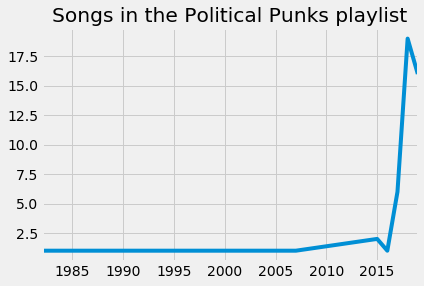

In [96]:
political_df = df[df.playlist_name == "Political Punks"]
political_df.song_release_date.value_counts().sort_index().plot(title='Songs in the Political Punks playlist')

In [142]:
playlists_df = pd.DataFrame(df.groupby('artist_name').playlist_name.value_counts()).rename(columns={"playlist_name": 'playlists_in'}).reset_index()

def get_list(x):
    playlists = []
    if x.artist_name == x.artist_name:
        playlists.append(x.playlist_name)
    return playlists

playlists_df.apply(get_list, axis=1)
playlists_df.head()

,artist_name,playlist_name,playlists_in
0,25 Ta Life,Classic Hardcore,2
1,311,Covered In Punk,1
2,7 Year Bitch,Grrrls To The Front,1
3,A Day To Remember,Crash Course,1
4,A Day To Remember,New Punk Tracks,1


In [148]:
artist_counts_df = pd.DataFrame(df.groupby('artist_name').playlist_name.nunique().sort_values(ascending=False)).rename(columns={"playlist_name": 'playlists_in'}).reset_index()
artist_counts_df['total'] = df.playlist_name.unique().shape[0]
artist_counts_df['percent_in'] = (artist_counts_df['playlists_in'] / artist_counts_df['total']) * 100
artist_counts_df['genres'] = df.artist_genres
artist_counts_df.genres = artist_counts_df.genres.replace("[\[\]']","", regex=True)
# artist_counts_df.genres = artist_counts_df.genres.str.replace(', ','","')
# artist_counts_df.genres = artist_counts_df.genres.str.replace('^(\w)', '"\\1', regex=True)
# artist_counts_df.genres = artist_counts_df.genres.str.replace('(\w)$', '\\1"', regex=True)
artist_counts_df.head(10).to_csv('artist_counts.csv', index=False)
artist_counts_df.head(10).genres

0    pop punk, punk, socal pop punk                                                                                              
1    anthem emo, pixie, pop emo, pop punk                                                                                        
2    alternative emo, dreamo, emo, modern rock, pop punk, post-hardcore, screamo                                                 
3    metalcore, pop punk, post-screamo, screamo                                                                                  
4    punk, ska punk, skate punk                                                                                                  
5    anthem emo, easycore, melodic hardcore                                                                                      
6    canadian folk, canadian pop, electropop, indie poptimism, indietronica                                                      
7    post-screamo                                                                         

In [101]:
def to_list(x):
    return list(x.split(','))

artist_counts_df.head(10).genres.apply(lambda x: to_list(x))

0    [pop punk, punk, socal pop punk]                                                                                              
1    [anthem emo, pixie, pop emo, pop punk]                                                                                        
2    [alternative emo, dreamo, emo, modern rock, pop punk, post-hardcore, screamo]                                                 
3    [metalcore, pop punk, post-screamo, screamo]                                                                                  
4    [punk, ska punk, skate punk]                                                                                                  
5    [anthem emo, easycore, melodic hardcore]                                                                                      
6    [canadian folk, canadian pop, electropop, indie poptimism, indietronica]                                                      
7    [post-screamo]                                                         

In [99]:
for artist in artist_counts_df.head(10).genres:
#     print(artist)
    print(list(artist.split(',')))
#     new_genres['genre'] = (list(artist.split(',')))
    
pd.DataFrame(new_genres)

['pop punk', 'punk', 'socal pop punk']
['anthem emo', 'pixie', 'pop emo', 'pop punk']
['alternative emo', 'dreamo', 'emo', 'modern rock', 'pop punk', 'post-hardcore', 'screamo']
['metalcore', 'pop punk', 'post-screamo', 'screamo']
['punk', 'ska punk', 'skate punk']
['anthem emo', 'easycore', 'melodic hardcore']
['canadian folk', 'canadian pop', 'electropop', 'indie poptimism', 'indietronica']
['post-screamo']
['canadian punk', 'hamilton on indie', 'indie punk']
['alternative emo', 'emo', 'heartland rock', 'indie punk', 'melodic hardcore', 'modern rock', 'orgcore', 'philly indie', 'pop punk', 'skate punk']


,genre
0,alternative emo
1,emo
2,heartland rock
3,indie punk
4,melodic hardcore
5,modern rock
6,orgcore
7,philly indie
8,pop punk
9,skate punk


In [74]:
for playlist in df.artist_name.unique()

array(['blink-182', 'Stand Atlantic', 'Bayside', 'Our Last Night',
       'Tsunami Bomb', 'Capstan', 'Lights', 'Lonely Avenue',
       'The Dirty Nil', 'The Menzingers', "Can't Swim", 'Mudhoney',
       'Belmont', 'Tiny Stills', 'Summer Heights',
       'Ready Steady Steroids', 'Waco', 'Misery Loves Company', 'Snuff',
       'Tiny Moving Parts', 'Green Day', 'Fall Out Boy', 'Raised Fist',
       'Microwave', 'Refused', 'Waterparks', 'Agnostic Front', 'WSTR',
       'Sleep On It', 'Tiger Army', 'Mest', 'Touché Amoré',
       'Boys of Fall', 'Pixies', 'Chastity', 'Assuming We Survive',
       'Cursive', 'Deez Nuts', 'MakeWar', 'Storyteller',
       'The Anti-Queens', 'Locket', 'Alone I Walk', 'These Five Years',
       'Not Ur Girlfrenz', 'Drakulas', 'Bony Macaroni', 'Subhumans',
       'Bob Mould', 'Avoid One Thing', 'Spermbirds', 'Wayfarer', 'ROAM',
       'Sleeping With Sirens', 'Teenage Bottlerocket', 'Lagwagon',
       'Grayscale', 'Gideon', 'Iggy Pop', 'Senses Fail',
       'The Ea

In [73]:
df.artist_name.value_counts().

Various Artists                 42
Green Day                       22
Taking Back Sunday              14
Punk Goes                       12
Neck Deep                       10
Real Friends                    9 
Trash Boat                      9 
Bayside                         9 
blink-182                       8 
Alexisonfire                    8 
Seaway                          8 
Stand Atlantic                  7 
Thursday                        7 
The Story So Far                7 
Silverstein                     7 
WSTR                            7 
The Dangerous Summer            6 
Point North                     6 
Senses Fail                     6 
Good Riddance                   6 
Tiger Army                      6 
Tiny Moving Parts               6 
Misfits                         6 
Moose Blood                     6 
PUP                             6 
The Menzingers                  6 
Underoath                       6 
ROAM                            6 
H2O                 

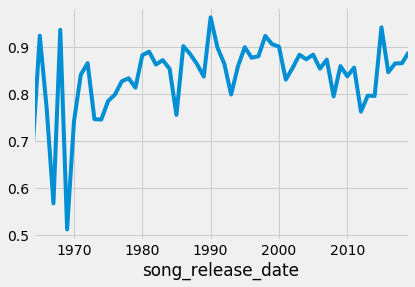

In [24]:
plt.style.use('fivethirtyeight')
df.groupby('song_release_date').energy.mean().plot()

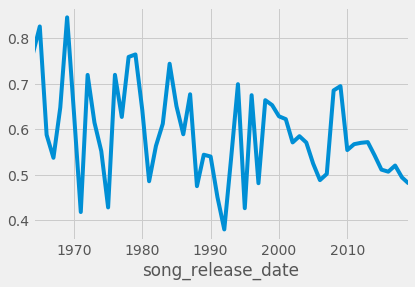

In [82]:
plt.style.use('fivethirtyeight')
df.groupby('song_release_date').valence.mean().plot()

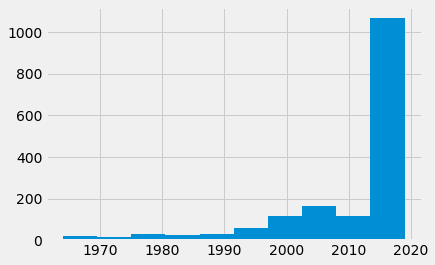

In [25]:
df.song_release_date.hist()

In [91]:
recent_df = df[df.song_release_date > 2017]

In [55]:
recent_df.keys()

Index(['acousticness', 'analysis_url', 'artist_followers', 'artist_genres',
       'artist_name', 'artist_popularity', 'danceability', 'duration_ms',
       'energy', 'error', 'id', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'playlist_api', 'playlist_link', 'playlist_name',
       'song_album', 'song_explicit', 'song_id', 'song_length', 'song_name',
       'song_popularity', 'song_preview', 'song_release_date', 'speechiness',
       'tempo', 'time_signature', 'track_href', 'type', 'uri', 'valence'],
      dtype='object')

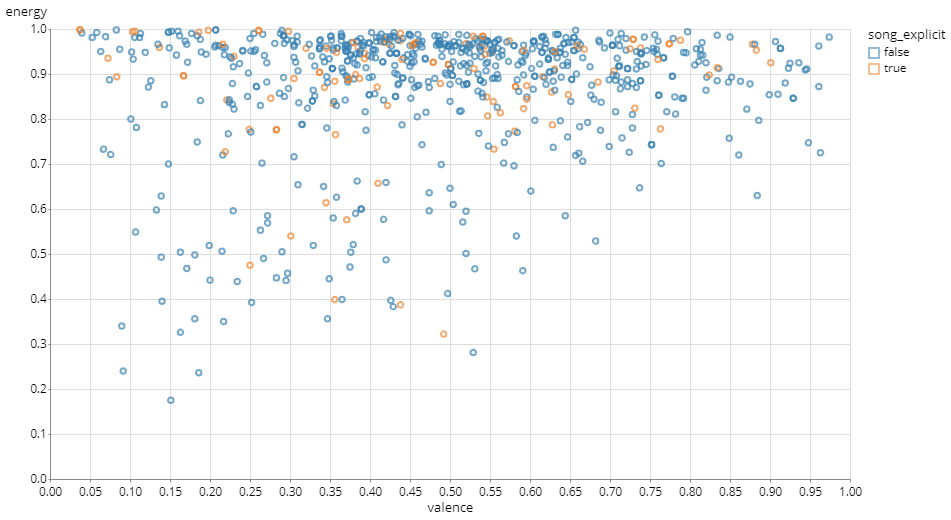

In [92]:
source = recent_df

alt.Chart(source).mark_point().encode(
    x='valence',
    y='energy',
    color='song_explicit',
#     size='loudness'
)

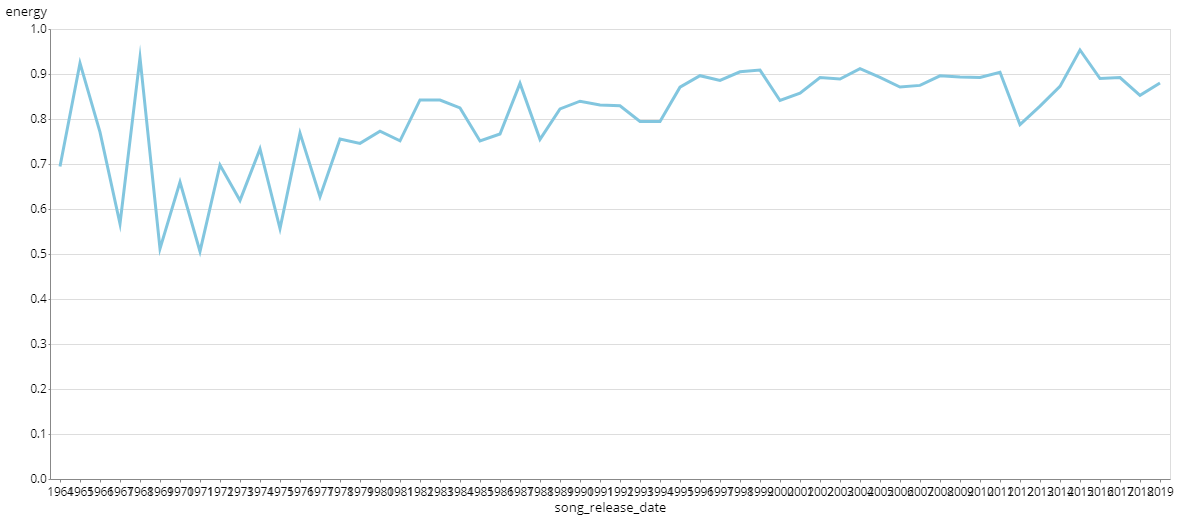

In [43]:
alt.Chart(pd.DataFrame(df.groupby('song_release_date').energy.mean()).reset_index()).mark_line().encode(
    x='song_release_date',
    y='energy'
)

In [42]:
pd.DataFrame(df.groupby('song_release_date').energy.mean()).reset_index()

,song_release_date,energy
0,1964,0.694500
1,1965,0.924000
2,1966,0.770857
3,1967,0.567200
4,1968,0.936500
5,1969,0.511667
6,1970,0.659857
7,1971,0.505692
8,1972,0.697800
9,1973,0.619091
